# __Option Pricing by Monte Carlo Methods__

<br>

Finance 5350: Computational Financial Modeling <br>
Tyler J. Brough <br>
November 4, 2018 <br>

# __Table of Contents__

1. Simulating Geometric Brownian Motion

2. Risk-Neutral Monte Carlo

3. Hedging Monte Carlo

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## __Simulating Geometric Brownian Motion__

Recall that the spot price dynamics of the binomial model are given by:

<br>
$$
S_{t+h} = S_{t} e^{\{(r - \delta) h \pm \sigma \sqrt{h} \}}
$$

And we recall that with this model we were accomplishing a binomial approximation to a log-normal distribution for stock prices at expiry. We move now to simulating prices directly from the log-normal model. This model of stock prices is called discrete time Geometric Brownian Motion.

<br>
$$
S_{t+h} = S_{t} e^{\{(r - \delta - \frac{1}{2} \sigma^{2}) h + \sigma \sqrt{h} z\}}
$$
<br>

where $z$ is a draw from a standard normal distribution.

Let's start with our familiar example: 

- $S_{0} = \$41.0$
- $K = \$40.0$
- $\sigma = 0.30$
- $r = 0.08$ 
- $\delta = 0.0$
- $T = 1.0$ years

Let's simulate daily prices in `Python` for a single path.

Also, recall our code to plot a price path.

In [3]:
def plotPricePath(path):
    nsteps = path.shape[0]
    plt.plot(path, 'b', linewidth = 2.5)
    plt.title("Simulated Binomial Price Path")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price ($)")
    plt.xlim((0, nsteps))
    plt.grid(True)
    plt.show()

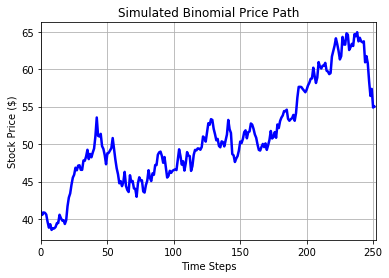

In [4]:
S = 41.0
K = 40.0
v = 0.30
r = 0.08
q = 0.0
T = 1.0
n = 252
h = T / n

path = np.zeros(n)
z = np.random.normal(size=n)
path[0] = S

for t in range(1, n):
    path[t] = path[t-1] * np.exp((r - q - 0.5 * v * v) * h + v * np.sqrt(h) * z[t])
    
plotPricePath(path)

Recall our function to simulate many binomial price paths.

In [4]:
def AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps):
    paths = np.empty((nreps, nsteps + 1))
    h = expiry / nsteps
    u = np.exp((mu - div) * h + sigma * np.sqrt(h))
    d = np.exp((mu - div) * h - sigma * np.sqrt(h))
    p = (np.exp((mu - div) * h) - d) / (u - d)
    paths[:,0] = spot

    for i in range(nreps):
        w = np.random.uniform(size=nsteps)
        for j in range(nsteps):
            if w[j] >= p: 
                paths[i, j + 1] = paths[i, j] * u
            else:
                paths[i, j + 1] = paths[i, j] * d

    return paths

We can replace this with a function that does the same thing, but that simulates discrete-time GBM.

In [5]:
def AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps):
    paths = np.empty((nreps, nsteps + 1))
    h = expiry / nsteps
    paths[:, 0] = spot
    mudt = (mu - div - 0.5 * sigma * sigma) * h
    sigmadt = sigma * np.sqrt(h)
    
    for t in range(1, nsteps + 1):
        z = np.random.normal(size=nreps)
        paths[:, t] = paths[:, t-1] * np.exp(mudt + sigmadt * z)

    return paths

In [6]:
paths = AssetPaths(41.0, 0.10, 0.30, 1.0, 0.0, 10, 252)

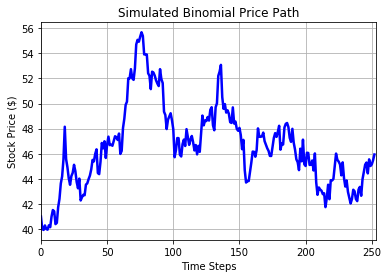

In [7]:
plotPricePath(paths[1])

In [8]:
paths

array([[ 41.        ,  42.09742151,  42.22587607, ..., 111.88990844,
        112.72761493, 112.6539877 ],
       [ 41.        ,  39.99929185,  39.93300138, ...,  45.15386255,
         45.49008363,  45.93932192],
       [ 41.        ,  40.63577945,  41.13298506, ...,  33.71825226,
         34.26395671,  35.01651908],
       ...,
       [ 41.        ,  41.69295523,  41.39510917, ...,  50.39455719,
         49.22050162,  49.35040292],
       [ 41.        ,  39.90898198,  39.7311435 , ...,  40.37394317,
         39.5493616 ,  38.7028576 ],
       [ 41.        ,  40.90488786,  40.37651307, ...,  84.4746303 ,
         84.04884203,  84.83552654]])

## __Risk-Neutral Monte Carlo (RNMC)__

With the ability to simulate discrete-time GBM, we can think about how to use Monte Carlo simulation to price options. We will begin with a European call option (with the data given as above). 

We recall from the binomial model that under the risk-neutral density we could think of the option price as the discounted expected payoff of the option: 

<br>
$$
C_{0} = e^{(-r T)} \left[p^{\ast} C_{u} + (1 - p^{\ast}) C_{d} \right]
$$
<br>

We can generalize this as: 

<br>
$$
C_{0} = e^{(-r T)} E^{\ast}\left[C_{T}\right]
$$
<br>

Let's get functions for the BSM call and put prices as follows:

In [9]:
def bsmCallPrice(S, K, r, v, q, T):
    d1 = (np.log(S/K) + (r - q + 0.5 * v * v) * T) / (v * np.sqrt(T))
    d2 = (np.log(S/K) + (r - q - 0.5 * v * v) * T) / (v * np.sqrt(T))
    callPrc = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return callPrc

def bsmPutPrice(S, K, r, v, q, T):
    d1 = (np.log(S/K) + (r - q + 0.5 * v * v) * T) / (v * np.sqrt(T))
    d2 = (np.log(S/K) + (r - q - 0.5 * v * v) * T) / (v * np.sqrt(T))
    putPrc =  K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
    return putPrc   

print(f"The BSM Call Price is: {bsmCallPrice(41.0, 40.0, 0.08, 0.30, 0.0, 1.0) : 0.2f}")
print(f"The BSM Put Price is: {bsmPutPrice(41.0, 40.0, 0.08, 0.30, 0.0, 1.0) : 0.2f}")

The BSM Call Price is:  6.96
The BSM Put Price is:  2.89


We can approximate this using Monte Carlo with the following:

<br>
$$
\hat{C_{0}} = e^{(-r T)} \frac{1}{m}\sum\limits_{j=1}^{m} C_{T, j}
$$
<br>

where $C_{T,j}$ is the payoff of the $j^{th}$ simulated price and $m$ is the number of replications in the simulation. _This almost seems too easy!_

In [10]:
def callPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

S = 41.0
K = 40.0
r = 0.08
v = 0.30
q = 0.0
T = 1.0
m = 100000
n = 252

paths = AssetPaths(S, r, v, T, q, m, n)
callT = callPayoff(paths[:, -1], K)
callPrc = callT.mean()
callPrc *= np.exp(-r * T)
print(f"The Call Price by RNMC is: {callPrc : 0.2f}")

The Call Price by RNMC is:  6.89


Recall that the BSM price for this option is $\$6.96$. We are using the Central Limit Theorem to approximate the sampling distribution of the estimator $\hat{C_{0}}$. We may need many more paths to get more accuracy. 

We can of course price a put option as well.

In [11]:
def putPayoff(spot, strike):
    return np.maximum(strike - spot, 0.0)

putT = putPayoff(paths[:, -1], K)
putPrc = putT.mean()
putPrc *= np.exp(-r * T)
print(f"The Put Price by RNMC is: {putPrc : 0.2f}")

The Put Price by RNMC is:  2.88


Again, we may need more replications to achieve greater accuracy. 

___NB:___ we are simulating prices under the risk-neutral density. This assumes that replication is happening perfectly. The BSM equation is equivalent to infinitely many Monte Carlo paths. We would not use Monte Carlo in this world, but it does provide a convenient testing grounds since we can compare with the theoretical values. 

## __Hedging Monte Carlo (HMC)__

The logic behind the BSM method is to price the cost of the replication trading strategy and apply the _Law of One Price_ (also called the _No-Arbitrage Principle_) to infer the price of the option. 

We can use Monte Carlo simulation to better understand this implied trading strategy. 

___NB:___ under this approach we will simulate prices in the physical, objective, historical, or real-world density rather than the risk-neutral density. Thus, for these examples we will assume that we somehow are privy to risky discount rate of the option. 


### The Stop-Loss Strategy

We first turn our attention to a simplified trading strategy that we can examine by Monte Carlo methods, namely the stop-loss strategy. This strategy specifies that the market-maker hedge the option completely with a 1-for-1 hedge ratio whenever the option is in-the-money and remain unhedged when the option is out-of-the-money (that is hold no shares of the underlying asset). 

In [12]:
def stopLoss(S, K, mu, sigma, r, T, paths):
    df = np.exp(-r * np.arange(n) * h)
    covered = False
    costs = np.zeros(m)

    for k in range(m):
        path = paths[k]
        cashFlows = np.zeros(n)
        if path[0] >= K: 
            covered = True
            cashFlows[0] = -path[0]

        for t in range(1, n):
            if covered and (path[t] < K):
                covered = False
                cashFlows[t] = path[t]
            elif not covered and (path[t] > K):
                covered = True
                cashFlows[t] = -path[t]
            else:
                continue

        if (path[-1] >= K):
            cashFlows[-1] = cashFlows[-1] + K

        costs[k] = -np.dot(df, cashFlows)

    return np.mean(costs)
    

In [13]:
S = 50.0
K = 50.0
r = 0.05
mu = 0.10
v = 0.40
T = 5.0 / 12.0
m = 100000
n = 110

print(f"The BSM Call Price is: {bsmCallPrice(S, K, r, v, q, T) : 0.4f}")

The BSM Call Price is:  5.6150


In [14]:
paths = AssetPaths(S, mu, v, T, q, m, n) # notice that we use mu and not r!
callPrc = stopLoss(S, K, mu, v, r, T, paths)
print(f"The Stop Loss Monte Carlo Price is: {callPrc : 0.4f}")

The Stop Loss Monte Carlo Price is:  5.6147


### The Delta Hedging Strategy

The stop-loss strategy demonstrates some mispricing, but works surprisingly well for such a simple strategy. It gives us some great insight into the BSM dynamic replication strategy even though it's hedging mechanism is far less than optimal. 

<br>

We can see how to improve upon the strategy by dynamically delta hedging the replication portfolio. 

<br>

We examine dynamic delta hedging at the daily level next.

In [15]:
def bsmCallDelta(S, K, r, v, q, tau):
    d1 = (np.log(S/K) + (r - q + 0.5 * v * v) * T) / (v * np.sqrt(T))
    
    return np.exp(-q * T) * norm.cdf(d1)

In [16]:
def deltaHedging(S, K, mu, sigma, r, T, paths):
    m, n = paths.shape
    cost = np.zeros(m)
    cashFlows = np.zeros(n)
    h = T / n
    df = np.exp(-r * np.arange(n) * h)
    tau = T - np.arange(n) * h
    
    for k in range(m):
        path = paths[k]
        position = 0.0
        deltas = bsmCallDelta(path, K, r, v, q, tau)
        
        for t in range(n):
            cashFlows[t] = (position - deltas[t]) * path[t]
            position = deltas[t]
            
        if (path[-1] >= K):
            cashFlows[-1] = K - (1 - position) * path[-1]
        else:
            cashFlows[-1] = position * path[-1]
        
        cost[k] = -np.dot(df, cashFlows)
        
    return np.mean(cost)

In [17]:
paths = AssetPaths(S, mu, v, T, q, m, n)
delHdgPrc = deltaHedging(S, K, mu, v, r, T, paths)
bsmPrc = bsmCallPrice(S, K, r, v, q, T)
print(f"The BSM Call Price is: {bsmPrc : 0.4f}")
print(f"The Delta-Hedging Monte Carlo Call Price is: {delHdgPrc : 0.4f}")

The BSM Call Price is:  5.6150
The Delta-Hedging Monte Carlo Call Price is:  5.5716
